In [1]:
#%pip install pybamm -q    # install PyBaMM if it is not installed
import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
from matplotlib import style
style.use('ggplot')
start = timeit.default_timer()
os.chdir(pybamm.__path__[0]+'/..')
# pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.BasicDFNComposite()
chemistry = pybamm.parameter_sets.Chen2020_composite
param = pybamm.ParameterValues(chemistry=chemistry)
# model = pybamm.lithium_ion.DFN()
# param = model.default_parameter_values
param.update({"Upper voltage cut-off [V]": 4.5})
param.update({"Lower voltage cut-off [V]": 2})

C_rates = 0.01
t_evals = np.linspace(0, 7200 / C_rates, 200)
capacity = param["Nominal cell capacity [A.h]"]
current = C_rates * capacity


def I_fun(A):
    def current(t):
        capacity = 5
        C_rates = A / capacity
        period = 3600 / C_rates
        discharge = pybamm.sigmoid( t - period, 0, 1)
        charge = pybamm.sigmoid(- t + period, 0, 1)
        return A * discharge - A * charge
        # return A * (t < period) - A * (t >= period)
        # return A * 0.2 * pybamm.sin(2 * np.pi * t / 7200 )
    return current


param["Current function [A]"] = I_fun(current)

sim1 = pybamm.Simulation(
    model,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
)
solution = sim1.solve(t_eval=t_evals)
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

running time: 21.23767080000016s


In [3]:
# plot
plot = pybamm.QuickPlot( solution, [       
        "Current [A]",
        "Terminal voltage [V]",
        "X-averaged negative electrode open circuit potential of phase 1 [V]",
        "X-averaged negative electrode open circuit potential of phase 2 [V]",
    ]
)
plot.dynamic_plot()


interactive(children=(FloatSlider(value=0.0, description='t', max=200.0, step=2.0), Output()), _dom_classes=('…

In [4]:
current = solution["Current [A]"].entries
times = solution["Time [s]"].entries / 3600
voltage = solution["Terminal voltage [V]"].entries
ocp_p1 = solution["X-averaged negative electrode open circuit potential of phase 1 [V]"].entries
ocp_p2 = solution["X-averaged negative electrode open circuit potential of phase 2 [V]"].entries
ocp_chen = pd.read_csv ("wip/negative_ocp_LGM50.txt", delimiter= '\s+',header=None,comment='#')
capacity = current * 0
capacity_max = 0
time_discharge = 0
for i in range(0,len(current)):
    if current[i]>0:
        capacity[i] = times[i] * current[i]
        capacity_max = max(capacity_max, capacity[i])
        time_discharge = times[i]
    else:
        capacity[i] = capacity_max + (times[i] - time_discharge) * current[i]


Text(0.5, 1.0, 'Cell voltage [V]')

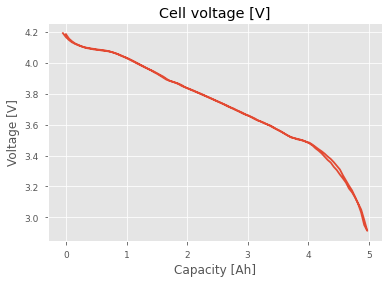

In [5]:
plt.plot(capacity,voltage)
plt.xlabel("Capacity [Ah]")
plt.ylabel("Voltage [V]")
plt.title("Cell voltage [V]")

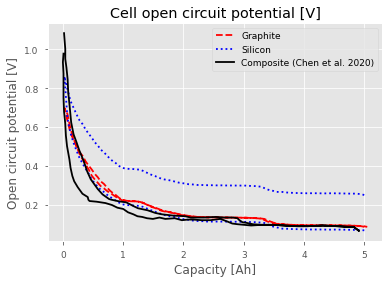

In [6]:
plt.plot(5-capacity,ocp_p1,'r--',label='Graphite')
plt.plot(5-capacity,ocp_p2,'b:',label='Silicon')
plt.plot(ocp_chen.values[:,0],ocp_chen.values[:,1],'k-',label='Composite (Chen et al. 2020)')
plt.xlabel("Capacity [Ah]")
plt.ylabel("Open circuit potential [V]")
plt.title("Cell open circuit potential [V]")
plt.legend()

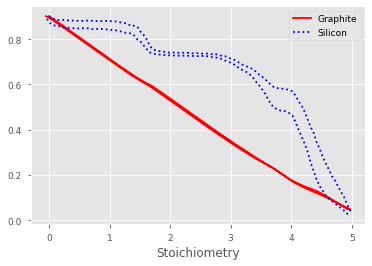

In [8]:
c_s_xrav_n_p1 = solution["Averaged negative electrode concentration of phase 1"].entries
c_s_xrav_n_p2 = solution["Averaged negative electrode concentration of phase 2"].entries
plt.plot(capacity, c_s_xrav_n_p1,'r-', label='Graphite')
plt.plot(capacity, c_s_xrav_n_p2, 'b:',label='Silicon')
plt.xlabel("Capacity [Ah]")
plt.ylabel("Stoichiometry")
plt.legend()